In [16]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn

In [25]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.set_default_device(device)

"""
加载数据
"""

data = pd.read_csv('filled_data.csv')

# 选择特征和标签
X = data[['SO2', 'NO', 'NO2', 'NOX', 'O3', 'temperature', 'wind_speed', 'relative_humidity', 'air_pressure']].values
y = data['PM2_5'].values

"""
数据预处理
"""

# 数据归一化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 转换为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).view(-1, 1)

# 创建DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

In [31]:
"""
定义模型
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 64)  # 9个输入特征
        self.lstm1 = nn.LSTM(64, 32)
        self.lstm2 = nn.LSTM(32,64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)  # 输出PM2.5的预测值

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x, _ = self.lstm1(x.unsqueeze(1))  # 将输入形状调整为 (batch_size, seq_len, input_size)
        x, _ = self.lstm2(x)  # 不需要再次增加维度
        x = torch.relu(x.squeeze(1))  # 去除seq_len维度
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
model = Net()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
"""
训练模型
"""

train_losses = []
test_losses = []

epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}')

Epoch 1/100, Train Loss: 123.93765778975053, Test Loss: 122.13455762509946
Epoch 2/100, Train Loss: 122.92296794261472, Test Loss: 120.53583766795971
Epoch 3/100, Train Loss: 121.46543729283151, Test Loss: 119.6811679981373
Epoch 4/100, Train Loss: 121.05705847943648, Test Loss: 118.73777013708045
Epoch 5/100, Train Loss: 119.78634066749814, Test Loss: 118.81464264481156
Epoch 6/100, Train Loss: 119.21192100539056, Test Loss: 117.47650397971825
Epoch 7/100, Train Loss: 118.48678925749543, Test Loss: 117.5626141583478
Epoch 8/100, Train Loss: 118.22406792154118, Test Loss: 116.99472924691659
Epoch 9/100, Train Loss: 117.67670687673707, Test Loss: 116.14189190334744
Epoch 10/100, Train Loss: 116.91491844304639, Test Loss: 116.53870027330187
Epoch 11/100, Train Loss: 116.58047297801511, Test Loss: 114.78445878205476
Epoch 12/100, Train Loss: 115.87990704892076, Test Loss: 115.27751252916124
Epoch 13/100, Train Loss: 115.56200946107202, Test Loss: 115.77066161544235
Epoch 14/100, Train Los

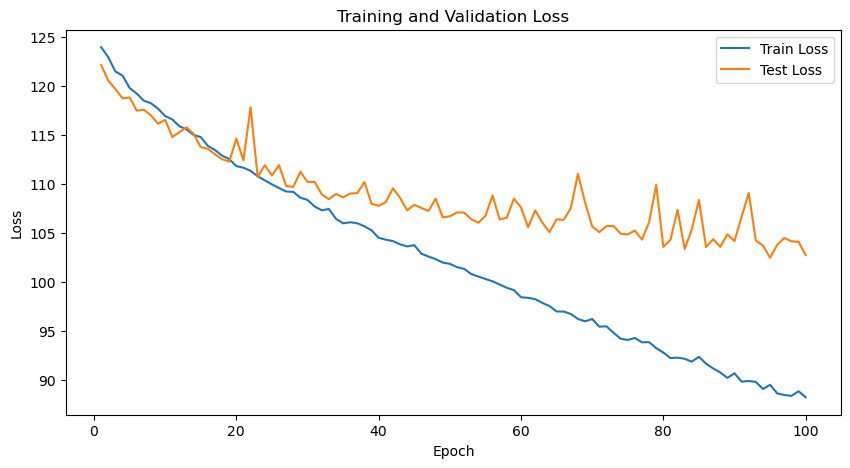

In [36]:
import matplotlib.pyplot as plt

# 绘制训练集和验证集的损失曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [37]:
"""
测试模型
"""
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        total += labels.size(0)
        correct += ((outputs - labels) ** 2).sum().item()
    print(f'Mean Squared Error on Test Set: {correct / total}')

Mean Squared Error on Test Set: 102.82380692570142
